Found 2485 files belonging to 3 classes.
Using 1988 files for training.
Using 497 files for validation.
Epoch 1/100
32/32 [==============================] - 18s 218ms/step - loss: 2.1554 - accuracy: 0.4572 - val_loss: 0.9247 - val_accuracy: 0.5553 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 6s 155ms/step - loss: 0.8404 - accuracy: 0.6122 - val_loss: 0.8031 - val_accuracy: 0.6258 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 6s 154ms/step - loss: 0.6353 - accuracy: 0.7319 - val_loss: 0.7247 - val_accuracy: 0.6861 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 6s 155ms/step - loss: 0.5469 - accuracy: 0.7832 - val_loss: 0.6342 - val_accuracy: 0.7284 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 6s 152ms/step - loss: 0.4735 - accuracy: 0.8174 - val_loss: 0.6976 - val_accuracy: 0.7022 - lr: 0.0010
Epoch 6/100
32/32 [==============================] - 6s 154ms/step - loss: 0.4173 - accuracy: 0.8400 - val_loss: 0.

None
None
INFO:__main__:None
/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


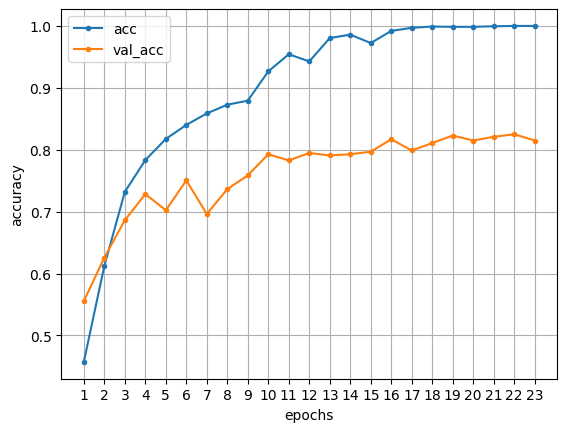

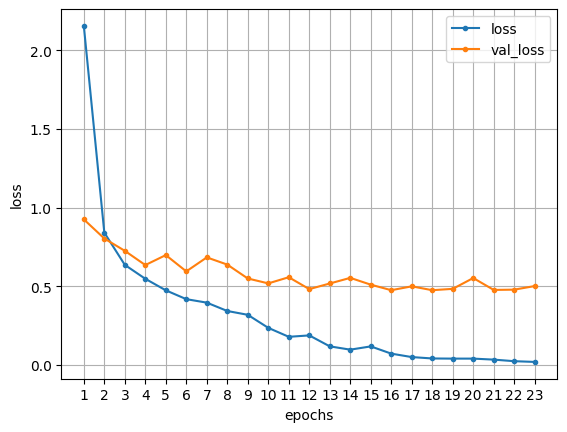

In [2]:
from gc import callbacks
from operator import call
import os
# os.chdir('/code/janken')
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Resizing, Permute
import matplotlib.pyplot as plt

import tensorflow_hub

import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

from janken_train import plot_result

SEED = 1234
IMG_DIR = './images'
BATCH_SIZE = 64
IMAGE_SIZE = 224
NUM_CLASSES = 3
N_EPOCHS = 100
LR = 1e-3

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=int(1e-6)),
]

def prepare_dataset():
    train_dataset, valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                            directory=IMG_DIR,
                                            label_mode='categorical',
                                            batch_size=BATCH_SIZE,
                                            image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            seed=SEED,
                                            validation_split=0.2,
                                            subset='both'
                                        )
    return train_dataset, valid_dataset

def define_model():
    base_model = tensorflow_hub.KerasLayer(
        "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/140-224-classification/versions/2",
        trainable=False,
    )
    
    return tf.keras.Sequential([
        base_model,
        Dense(1024, activation='relu'),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
# TODO: compare with https://github.com/osmr/imgclsmob/blob/master/tensorflow_/tensorflowcv/models/mobilenet.py
def main():
    train_dataset, valid_dataset = prepare_dataset()
    # TODO: prefetch

    model = define_model()
    
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=LR),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics = ['accuracy'],
    )

    history = model.fit(
        train_dataset,
        validation_data = valid_dataset,
        epochs = N_EPOCHS,
        verbose = 1,
        # class_weight=class_weight,
        callbacks = callbacks,
    )
    
    plot_result(history)
    logger.info(model.summary())
    model.save('test_model.h5')
    
if __name__ == '__main__':
    main()